# ML

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

## Data Analysis

### Load Data

- Load test_restaurant.csv as a DataFrame named `df`
- Transfer "date" to *datetime* from *str*
- Set "date" as index of `df`

In [2]:
df = pd.read_csv("test_restaurant.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index("date")
df.head()

,num_visitors
date,
2000-01-01,49.128490
2000-01-02,50.288060
2000-01-03,53.549213
2000-01-04,45.453240
2000-01-05,49.469402


- Check if there is any null value

In [3]:
sum(df.isnull().values)

array([0])

### Visulization

- Have a look on the "num_visitors" over time

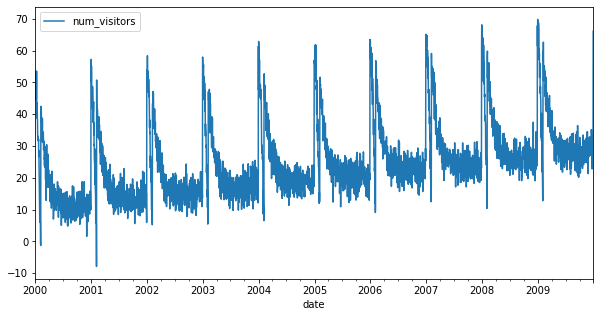

In [4]:
df.plot(figsize = (10, 5))

- We found there is an abnormal value, the negative "num_visitors". Since number of visitors cannot be negative, it is reasonable to consider it as 0.

In [5]:
df[df<0]=0

### Conclusion

- Now we can conclude our dataset with following features:
    1. Clean and simple data. We don't need to do further data processing.
    2. No independent variables to explain the value. The only data we have is the variable we need to predict. Hence, traditional machine learning methods like Regression, Trees are not applicable very well here.
    3. Time series data, with obvious trend and long-period seasonal. We will try to use time series methods to simulate and forecast. 

## Time Series Forecasting (Difference)

- When it comes to the time series analysis, the first thing is to get the stationary series so we can apply ARIMA and/or GARCH.

In [6]:
nv = df["num_visitors"]

- From the plot from Visulization, it is clear that the "num_visitors" is not stationary. To gain a stationary series, we need to difference the original data to eliminate the trend effect and the seasonal effect. Here by plotting the ACF plot (Autocorrelation), we can find that there is a peak approximately from 350 to 380. 

In [7]:
def tsplot(y, lags = None, figsize = (10,5), style='bmh'):
    with plt.style.context(style): 
        fig = plt.figure(figsize=figsize)
        layout = (1,2)
        pacf_ax = plt.subplot2grid(layout, (0,0))
        acf_ax = plt.subplot2grid(layout, (0,1)) 
        plot_pacf(y, lags = lags, ax=pacf_ax)
        plot_acf(y, lags = lags, ax=acf_ax)
        plt.tight_layout()
    return

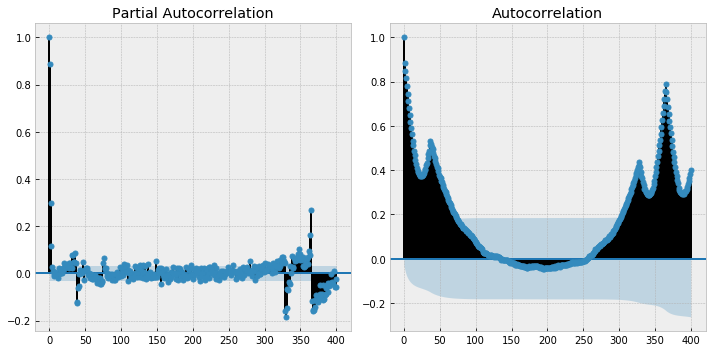

In [8]:
tsplot(nv, 400)

### Difference

- Even we don't know what the difference is at the peak, we can expect it is 365/366, days of one year. We continued to verify our guess and found that the series after the difference of 365, `nv_diff`, looks stationary now.

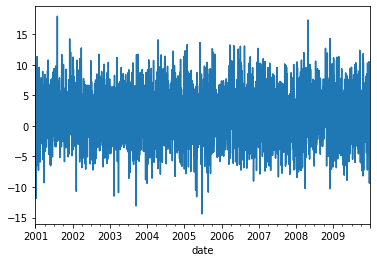

In [9]:
nv_diff = nv.diff(365).dropna()
nv_diff.plot()

- The Augmented Dickey Fuller test also justify our expectation. Here the p-value is 0.0 so that we reject the null hypothesis.

In [10]:
smt.stattools.adfuller(nv_diff)

(-58.114943845539884,
 0.0,
 0,
 3285,
 {'1%': -3.4323422122539857,
  '5%': -2.862420241278329,
  '10%': -2.567238570806373},
 18577.665466434144)

- Next, we want to utilize ARMA and GARCH on this stationary series. However, from the Ljung–Box test there is no significant partial autocorrelation or autocorrelation we can put in our ARMA model, or that is ARMA (0, 0). The series `nv_diff` seems like a White Noise.

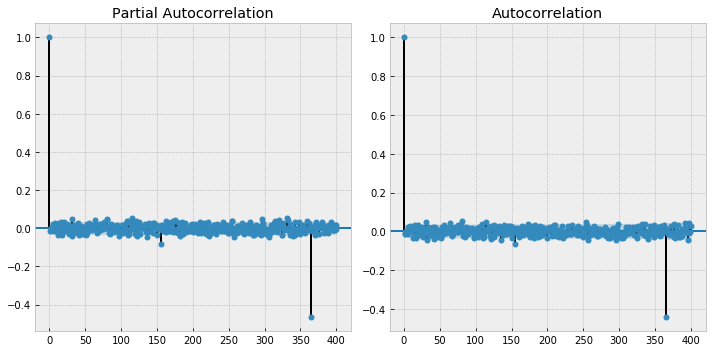

In [11]:
tsplot(nv_diff, 400)

In [12]:
sm.stats.diagnostic.acorr_ljungbox(nv_diff)

(array([ 0.65712844,  0.79968588,  0.83801798,  0.8566434 ,  2.26654872,
         2.99047773,  2.99091177,  5.63028882,  6.38235604,  7.52638347,
         7.54806056, 11.13724627, 14.13913078, 15.26649622, 15.7769121 ,
        19.79163424, 24.17696099, 26.10090215, 26.13938476, 29.23774166,
        29.52762585, 30.59189478, 31.67455732, 31.90925577, 33.63618593,
        33.64526889, 36.6990714 , 37.79475876, 38.03555627, 38.08054409,
        45.9255063 , 52.74389816, 52.78538758, 54.14256121, 56.33283544,
        57.32827941, 57.33284996, 57.79969641, 57.80054998, 59.60795794]),
 array([0.41757555, 0.67042534, 0.84035367, 0.93069693, 0.81116722,
        0.81004103, 0.88584169, 0.68856627, 0.70112401, 0.67499024,
        0.75312418, 0.51719476, 0.3641192 , 0.36018343, 0.39703122,
        0.22975234, 0.11470602, 0.09747309, 0.12635179, 0.08318261,
        0.1018994 , 0.10477359, 0.10710309, 0.12925897, 0.11591591,
        0.14419053, 0.10082288, 0.10234502, 0.12154761, 0.14769248,
      

### Normality

- Then, we'd like to focus on the properties of this difference series. By looking at the histogram as well as the qqplot, this series follows a normal distribution. 

[]

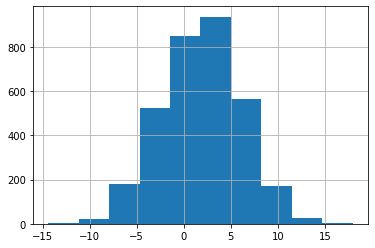

In [13]:
nv_diff.hist()
plt.plot()

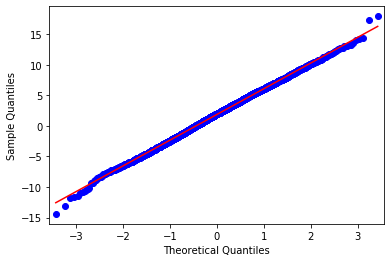

In [14]:
qqplot(nv_diff, line='s')
plt.show()

### T Test

- Further, using student's t-test we know that the mean of this series is not equal to zero. We should take it into consideration in our forecasting.

In [15]:
t_value = nv_diff.mean()/np.sqrt(nv_diff.var()/len(nv_diff))
t_value

25.31457497591261

### forecast

- Consequently we forecast the one-day forward value by using the "num_visitors" last year plus the mean of the difference series `nv_diff`.

In [16]:
forecast_value = nv_diff.mean() + nv[-365]
forecast_value

63.256827946205114

**Comment**: This method does forecast the one-day forward value reasonably. However, there are also rooms for future improvement:
    1. The difference method has a large variance on the forecast value. For example, in the last step "forecast", if we use `nv[-364]` or `nv[-366]`, the result will be very different. 
    2. As we noticed before, the PACF and ACF of the difference series `nv_diff` looks wired since the lag around 365 is somehow significant so that we should concern.
    3. The forecast process uses limited information when the main composition of the forecast value is one single data (the value in last year).

## Time Series Forecasting (Decomposition)

- To solve the problems of difference method, we turn to a more common approach in time series analysis, decomposition, where we decomposed the observed series (original value) into three part: Trend, Seasonal and Residual. In the last section, we have verified that 365 is proper both empirically and statistically, so here we use 365 as the frequency. 

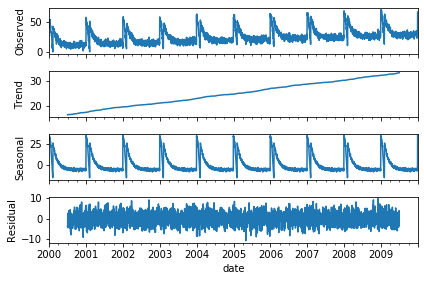

In [17]:
result = seasonal_decompose(df, model='additive', freq=365)
result.plot()
plt.show()

- We should be careful that three parts from the decomposition have different valid period. Then, we will construct our forecast models in these series respectively.

In [18]:
trend = result.trend.dropna()
trend.head()

,num_visitors
date,
2000-07-01,16.359505
2000-07-02,16.375590
2000-07-03,16.394623
2000-07-04,16.385868
2000-07-05,16.412692


In [19]:
seasonal = result.seasonal.dropna()
seasonal.head()

,num_visitors
date,
2000-01-01,34.993196
2000-01-02,33.409527
2000-01-03,34.516728
2000-01-04,32.657838
2000-01-05,33.525243


In [20]:
resid = result.resid.dropna()
resid.head()

,num_visitors
date,
2000-07-01,-3.797965
2000-07-02,0.882405
2000-07-03,2.553121
2000-07-04,-0.759317
2000-07-05,-4.487284


- The date to forecast is 2009-12-30

In [21]:
forecast_date = df.index[-1] + datetime.timedelta(days=1)
forecast_date

Timestamp('2009-12-30 00:00:00')

### forecast trend

- The plot of trend implies that linear model will be a good fit. So we use OLS for simulation and get the forecast trend value.

In [22]:
X = range(0, len(trend))
Y = trend.values
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
forecast_X = len(trend)- 1 + (forecast_date - trend.index[-1]).days
forecast_X = [1.0, forecast_X]
forecast_trend = results.predict(forecast_X)
forecast_trend

array([33.89963223])

### forecast seasonal

- Traditionally, the model of seasonal effect is handled using one hot encoding. Here it is too expensive to add a large number of dummy variables. Therefore, since we set the seasonal period as 365 days, we directly find the data the multiple of 365 days ago, e.g. 365, 730, 1095, etc. Undoubtedly, they have the same value, which we will take as our forecast seasonal value.

In [23]:
seasonal.iloc[range(-365, -len(seasonal), -365)]

,num_visitors
date,
2008-12-30,33.409527
2007-12-31,33.409527
2006-12-31,33.409527
2005-12-31,33.409527
2004-12-31,33.409527
2004-01-01,33.409527
2003-01-01,33.409527
2002-01-01,33.409527
2001-01-01,33.409527


In [24]:
forecast_seasonal = seasonal.iloc[range(-365, -len(seasonal), -365)].mean()
forecast_seasonal

num_visitors    33.409527
dtype: float64

### forecast resid

- The Augmented Dickey Fuller shows that the residual series is stationary.

In [25]:
smt.stattools.adfuller(resid["num_visitors"])

(-58.740961609467654,
 0.0,
 0,
 3286,
 {'1%': -3.4323416055066382,
  '5%': -2.86241997328205,
  '10%': -2.5672384281310743},
 16020.530765764743)

- Again, we try to utilize ARMA and GARCH on the residual. However, there are no valid Partial Autocorrelation and Autocorrelation we can put in ARMA model or that is ARMA (0, 0), illustrated by the Ljung–Box test. Fortunately, the ACF and PACF looks better than the plots in last section, which supports that Decomposition method fits very well on our data.

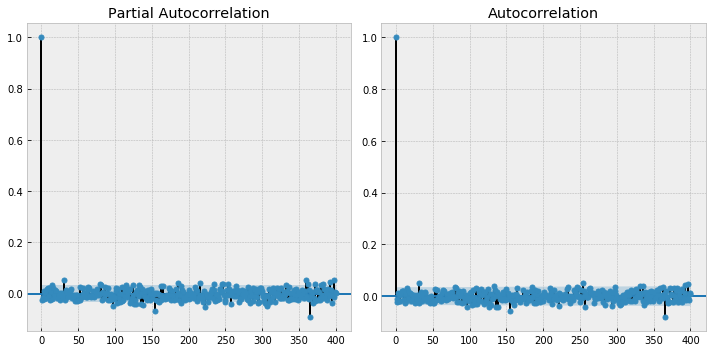

In [26]:
tsplot(resid["num_visitors"], 400)

In [27]:
sm.stats.diagnostic.acorr_ljungbox(resid["num_visitors"])

(array([ 1.97753593,  2.52292766,  2.92407216,  4.35827574,  4.4073442 ,
         5.48699984,  5.88585748,  7.01907743,  8.3625026 ,  9.89884021,
        10.30404439, 12.63675158, 12.80469103, 14.22292073, 17.84750203,
        19.31958545, 19.49163801, 19.91139848, 20.31474811, 20.5151678 ,
        21.68725719, 22.28363268, 22.30584051, 22.30951249, 22.39413883,
        24.44281436, 24.8096663 , 24.9256896 , 25.11768978, 25.93295625,
        34.93186074, 37.26722271, 37.31971615, 38.22157085, 39.24159017,
        39.24170597, 39.60379903, 39.77261453, 40.24816081, 41.08285383]),
 array([0.15965023, 0.28323911, 0.40348051, 0.35968457, 0.49237534,
        0.48302934, 0.55313877, 0.53457576, 0.49806735, 0.44941284,
        0.50326335, 0.39598634, 0.46300867, 0.4332388 , 0.27076771,
        0.25243932, 0.30105275, 0.33782993, 0.37586666, 0.42614593,
        0.41771988, 0.44307222, 0.50185809, 0.56079892, 0.61289576,
        0.55066044, 0.58512779, 0.63187698, 0.67212614, 0.67854922,
      

- Then, doing the same analysis as the last section, we found that the residual series also follows the normal distribution but has an insignificant mean that we can consider it as 0.

[]

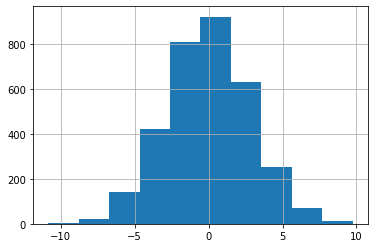

In [28]:
resid["num_visitors"].hist()
plt.plot()

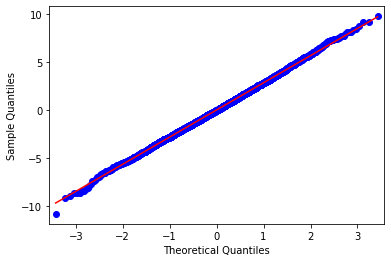

In [29]:
qqplot(resid["num_visitors"], line='s')
plt.show()

In [30]:
t_value = resid["num_visitors"].mean()/np.sqrt(resid["num_visitors"].var()/len(resid["num_visitors"]))
t_value

-0.18286434335173218

In [31]:
forecast_resid = 0.0

### composition

- Finally we composite three parts together based on additive rule, which is the reasoning how we decomposed the observed series.

In [32]:
forecast_value = forecast_trend + forecast_seasonal + forecast_resid
forecast_value

num_visitors    67.309159
dtype: float64

**Comment**: Decomposition method does a better job on forecasting the one-day forward value reasonably. It involves more information and performs more robust. However, we can further improve it from the following aspects:
    1. Since the leap year have 366 days rather than 465, which may undermine the accuracy in the long term, we can construct more detailed seasonal model.
    2. Even though the PACF and ACF of the residual series looks better now, it is still not perfectly statistical reasonable. Some large lags seems not completely insignificant, which may be predictive using proper model.
    3. The analysis is still under the structure of time series analysis, other statistical model like Deep Learning may fit the data better.